# Sub-selecting DESI Spectra

If your analysis requires only a small subset of DESI spectra, it can be useful
to subselect the spectra of interest ahead of time and save those separately so
that subsequent analysis steps can start with a much smaller curated file instead
of re-reading and re-filtering the original files every time.

This tutorial shows some utility features in desispec for reading, sub-selecting,
combining, and writing spectra.  It also shows how to associate a catalog with
spectra that can be written to the same output file and read back in.

*Stephen Bailey (LBL)*<br/>
*September 2023*

In [1]:
import os
import numpy as np
import desispec.io
from desispec.spectra import stack

## Slicing (sub-selecting) Spectra

`desispec.io.read_spectra(filename)` returns a `Spectra` object that can be sliced (sub-selected) using notation like numpy arrays.  We'll start by reading an example coadd spectra file from the "fuji" production included with the DESI Early Data Release (EDR).

In [2]:
fujidir = os.path.expandvars('$DESI_ROOT/spectro/redux/fuji')
specfile = f'{fujidir}/tiles/cumulative/100/20210505/coadd-0-100-thru20210505.fits'
spectra = desispec.io.read_spectra(specfile)
print('There are {} spectra in {}'.format(spectra.num_spectra(), os.path.basename(specfile)))

INFO:spectra.py:372:read_spectra: iotime 1.054 sec to read coadd-0-100-thru20210505.fits at 2023-09-20T16:10:36.738042
There are 500 spectra in coadd-0-100-thru20210505.fits


Spectra can be sliced like numpy arrays using arrays of booleans, arrays of integer indices, or Python slices.

In [3]:
print('Original number of spectra:', spectra.num_spectra())
print()

# subset with boolean array
keep = spectra.fibermap['FIBER'] % 50 == 0
subset1 = spectra[keep]
print('Subset 1 selected with boolean array FIBER%50==0 -> {} spectra'.format(subset1.num_spectra()))
print(subset1.fibermap['FIBER', 'TARGETID'])
print()

# subset with integer indices
keep_indices = [10,30,452]
subset2 = spectra[keep_indices]
print('Subset 2 selected with index array {} -> {} spectra'.format(keep_indices, subset2.num_spectra()))

# confirm that these actually match the original subset
ok = np.all(spectra.fibermap['TARGETID'][keep_indices] == subset2.fibermap['TARGETID'])
print('TARGETIDs match:', ok)
print(subset2.fibermap['FIBER', 'TARGETID'])
print()

# subset with Python slice notation
subset3 = spectra[10:15]
print('Subset 3 selected with spectra[10:15] -> {} spectra'.format(subset3.num_spectra()))

ok = np.all(spectra.fibermap['TARGETID'][10:15] == subset3.fibermap['TARGETID'])
print('TARGETIDs match:', ok)
print(subset3.fibermap['FIBER', 'TARGETID'])


Original number of spectra: 500

Subset 1 selected with boolean array FIBER%50==0 -> 10 spectra
FIBER      TARGETID     
----- ------------------
    0 616094145466860255
   50  39633393171825713
  100  39633399102572725
  150  39633390172898751
  200  39633396153974983
  250  39633399102574156
  300  39633390181286972
  350  39633396153976678
  400  39633404941045627
  450  39633393176021808

Subset 2 selected with index array [10, 30, 452] -> 3 spectra
TARGETIDs match: True
FIBER      TARGETID    
----- -----------------
   10 39633396149780852
   30 39633396145589048
  452 39633390177093311

Subset 3 selected with spectra[10:15] -> 5 spectra
TARGETIDs match: True
FIBER      TARGETID     
----- ------------------
   10  39633396149780852
   11           -1000237
   12  39633396149781848
   13  39633396149780580
   14 616094148449009805


## Stacking spectra

Multiple Spectra objects can be re-combined into a single Spectra
object using `desispec.spectra.stack(list_of_spectra)`.

In [4]:
combined_spectra = stack([subset1, subset2, subset3])

print('combined_spectra has {} spectra, generated from subsets with {}, {}, and {} spectra'.format(
    combined_spectra.num_spectra(), subset1.num_spectra(), subset2.num_spectra(), subset3.num_spectra()))

combined_spectra has 18 spectra, generated from subsets with 10, 3, and 5 spectra


## Exercise

Note that index 10 is included in both subset2 (indices 10,30,452) and subset3 (slice 10:15).
Check `combined_spectra.fibermap['FIBER', 'TARGETID']` to see if it is duplicated in the
stacked spectra or not.
If needed, how would you remove duplicates from input subsets prior to stacking?

## Sorting spectra

The same index slice notation can be used to sort Spectra objects.

In [5]:
focalplane_radius = np.sqrt(subset1.fibermap['MEAN_FIBER_X']**2 + subset1.fibermap['MEAN_FIBER_Y']**2)
subset1.fibermap['FOCALPLANE_RADIUS'] = focalplane_radius

print('Original order of the spectra:')
print(subset1.fibermap['TARGETID', 'FOCALPLANE_RADIUS'])

sort_indices = np.argsort(focalplane_radius)
subset1 = subset1[sort_indices]
print('\nOrder after sorting by focal plane radius:')
print(subset1.fibermap['TARGETID', 'FOCALPLANE_RADIUS'])


Original order of the spectra:
     TARGETID      FOCALPLANE_RADIUS
------------------ -----------------
616094145466860255          301.6674
 39633393171825713         275.26178
 39633399102572725         186.94934
 39633390172898751         341.90472
 39633396153974983         234.18489
 39633399102574156         183.96696
 39633390181286972         385.61755
 39633396153976678         258.99908
 39633404941045627         32.213264
 39633393176021808          339.2598

Order after sorting by focal plane radius:
     TARGETID      FOCALPLANE_RADIUS
------------------ -----------------
 39633404941045627         32.213264
 39633399102574156         183.96696
 39633399102572725         186.94934
 39633396153974983         234.18489
 39633396153976678         258.99908
 39633393171825713         275.26178
616094145466860255          301.6674
 39633393176021808          339.2598
 39633390172898751         341.90472
 39633390181286972         385.61755


## Writing spectra

You can use `desispec.io.write_spectra` to write specta to a separate file
for subsequent analysis.  Here we'll write it to a file and then
read it back in to confirm we get the same thing.

In [6]:
outfile = os.path.expandvars('$SCRATCH/desi_spectra_subset.fits')
desispec.io.write_spectra(outfile, combined_spectra)

INFO:spectra.py:184:write_spectra: iotime 0.080 sec to write desi_spectra_subset.fits at 2023-09-20T16:10:37.204075


'/pscratch/sd/s/sjbailey/desi_spectra_subset.fits'

In [7]:
newspec = desispec.io.read_spectra(outfile)
ok = np.all(combined_spectra.fibermap['TARGETID'] == newspec.fibermap['TARGETID'])
print('TARGETIDs match:', ok)

ok = np.all(combined_spectra.flux['b'] == newspec.flux['b'])
print('fluxes match:', ok)

INFO:spectra.py:372:read_spectra: iotime 0.023 sec to read desi_spectra_subset.fits at 2023-09-20T16:10:37.235220
TARGETIDs match: True
fluxes match: True


## Worked example: Bright QSO subset

In this worked example, we'll find the 10 brightest z>2 QSOs in the SV1 survey DARK program,
read them in from their individual files, coadd them across cameras, and combine them
into a single Spectrum object to write to a separate file for further analysis.

In this case, we will already know the TARGETIDs that we want from the redshift catalog,
so we'll make use of `read_spectra(filename, targetids=...)` to read just the subset of
TARGETIDs that we want, instead of having to read the entire file and subselect the
spectra post-factor.

This section will also show how to associate the redshift catalog subset to the spectra so that
it can be written and read back in along with the spectra themselves, instead of having to be
tracked separately.

In [8]:
import fitsio
from astropy.table import Table
from desispec.coaddition import coadd_cameras

In [9]:
# Read the sv1-dark combined redshift catalog across all tiles
os.environ['SPECPROD'] = 'fuji'
fujidir = os.path.expandvars('$DESI_ROOT/spectro/redux/fuji')
zcatfile = f'{fujidir}/zcatalog/ztile-sv1-dark-cumulative.fits'
zcat = fitsio.read(zcatfile, 'ZCATALOG', columns=('TARGETID', 'TILEID', 'LASTNIGHT', 'PETAL_LOC', 'SPECTYPE', 'Z', 'ZWARN', 'FLUX_G'))

In [10]:
# subselect to confident z>2 QSOs
keep = (zcat['SPECTYPE']=='QSO') & (zcat['ZWARN']==0) & (zcat['Z']>2)
zcat = zcat[keep]

In [11]:
# sort by FLUX_G and print the brightest 10
ii = np.argsort(zcat['FLUX_G'])
bright_qso_zcat = Table(zcat[ii[-10:]])
print(bright_qso_zcat)

     TARGETID     LASTNIGHT         Z          ... PETAL_LOC   FLUX_G   TILEID
----------------- --------- ------------------ ... --------- ---------- ------
39628170290268893  20210404 2.0050244697713833 ...         6  59.962227  80893
39633315216492822  20210222  2.259111679446162 ...         4  61.812695  80712
39628523018653064  20210406 2.5714594724078568 ...         9    65.7126  80897
39627217130493416  20210116  2.544975906861089 ...         1    65.9629  80674
39628526546061698  20210109 2.6987046629928293 ...         2   70.07165  80682
39628511480121439  20210318 2.0897803029105906 ...         1  73.675964  80698
39628438411150843  20210318 2.0771515712878044 ...         7   74.12616  80856
39628454605358968  20210221  2.866434757277841 ...         5   88.01636  80708
39628210912103893  20210321  2.755069936210957 ...         3 118.559364  80859
39632950383345740  20210318 2.5001202098916853 ...         5  129.35292  80698


In [12]:
# Loop over the files that contain these targets and assemble the subsets.
# Note the use of read_spectra(filename, targetids=...) to filter while reading,
# instead of reading the entire file and filtering afterward.
spectra_list = list()
for tileid, night, petal in np.unique(bright_qso_zcat['TILEID', 'LASTNIGHT', 'PETAL_LOC']):
    coaddfile = desispec.io.findfile('coadd', tile=tileid, night=night, spectrograph=petal,
                                     groupname='cumulative')
    spectra = desispec.io.read_spectra(coaddfile, targetids=bright_qso_zcat['TARGETID'])
    spectra_camcoadd = coadd_cameras(spectra)
    spectra_list.append(spectra_camcoadd)

INFO:spectra.py:372:read_spectra: iotime 0.659 sec to read coadd-1-80674-thru20210116.fits at 2023-09-20T16:10:38.342144
INFO:spectra.py:372:read_spectra: iotime 0.884 sec to read coadd-2-80682-thru20210109.fits at 2023-09-20T16:10:39.264098
INFO:spectra.py:372:read_spectra: iotime 0.731 sec to read coadd-1-80698-thru20210318.fits at 2023-09-20T16:10:40.012767
INFO:spectra.py:372:read_spectra: iotime 0.800 sec to read coadd-5-80698-thru20210318.fits at 2023-09-20T16:10:40.831705
INFO:spectra.py:372:read_spectra: iotime 0.907 sec to read coadd-5-80708-thru20210221.fits at 2023-09-20T16:10:41.757240
INFO:spectra.py:372:read_spectra: iotime 0.865 sec to read coadd-4-80712-thru20210222.fits at 2023-09-20T16:10:42.640857
INFO:spectra.py:372:read_spectra: iotime 0.479 sec to read coadd-7-80856-thru20210318.fits at 2023-09-20T16:10:43.138647
INFO:spectra.py:372:read_spectra: iotime 1.036 sec to read coadd-3-80859-thru20210321.fits at 2023-09-20T16:10:44.193095
INFO:spectra.py:372:read_spectra

In [13]:
# stack those N>>1 subsets into a single Spectrum object
best_spectra = stack(spectra_list)

In [14]:
# Sort both the spectra and the zcat by TARGETID so that they
# are row-matched, and then attach zcat to spectra so that it
# will be included in output file
ii = np.argsort(best_spectra.fibermap['TARGETID'])
best_spectra = best_spectra[ii]

jj = np.argsort(bright_qso_zcat['TARGETID'])
bright_qso_zcat = bright_qso_zcat[jj]

assert np.all(best_spectra.fibermap['TARGETID'] == bright_qso_zcat['TARGETID'])

best_spectra.extra_catalog = bright_qso_zcat

In [15]:
# write output for further analysis
outfile = os.path.expandvars('$SCRATCH/desi_bright_qso.fits')
desispec.io.write_spectra(outfile, best_spectra)

INFO:spectra.py:184:write_spectra: iotime 0.056 sec to write desi_bright_qso.fits at 2023-09-20T16:10:46.267363


'/pscratch/sd/s/sjbailey/desi_bright_qso.fits'

Read it back in.
The bright_qso_zcat that we attached to the stacked spectra before
writing is now included as `qso.extra_catalog`.

In [16]:
# confirm that we can read it back in
qsos = desispec.io.read_spectra(outfile)
print(qsos.extra_catalog)

INFO:spectra.py:372:read_spectra: iotime 0.021 sec to read desi_bright_qso.fits at 2023-09-20T16:10:46.293740
     TARGETID     LASTNIGHT         Z          ... PETAL_LOC   FLUX_G   TILEID
----------------- --------- ------------------ ... --------- ---------- ------
39627217130493416  20210116  2.544975906861089 ...         1    65.9629  80674
39628170290268893  20210404 2.0050244697713833 ...         6  59.962227  80893
39628210912103893  20210321  2.755069936210957 ...         3 118.559364  80859
39628438411150843  20210318 2.0771515712878044 ...         7   74.12616  80856
39628454605358968  20210221  2.866434757277841 ...         5   88.01636  80708
39628511480121439  20210318 2.0897803029105906 ...         1  73.675964  80698
39628523018653064  20210406 2.5714594724078568 ...         9    65.7126  80897
39628526546061698  20210109 2.6987046629928293 ...         2   70.07165  80682
39632950383345740  20210318 2.5001202098916853 ...         5  129.35292  80698
39633315216492822  20

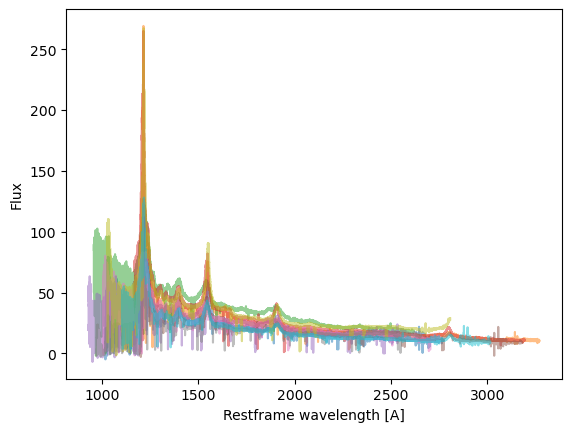

In [17]:
# plot them for fun
import matplotlib.pyplot as plt

for i in range(qsos.num_spectra()):
    z = qsos.extra_catalog['Z'][i]
    plt.plot(qsos.wave['brz']/(1+z), qsos.flux['brz'][i], alpha=0.5)

plt.xlabel('Restframe wavelength [A]')
plt.ylabel('Flux')
plt.show()

## Exercise

When reading in the spectra from multiple tiles, the code used
```python
for tileid, night, petal in np.unique(bright_qso_zcat['TILEID', 'LASTNIGHT', 'PETAL_LOC']):
    ...
```

What was the purpose of `np.unique(...)`?  Did it actually matter in this case?